# Install packages

In [ ]:
import os
import torch
import requests
from PIL import Image
from transformers import AutoProcessor, OmDetTurboForObjectDetection
from google.colab import drive
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.patches as patches


drive.mount('/content/drive')



Mounted at /content/drive


# Omdet-Turbo model loader

In [ ]:
processor = AutoProcessor.from_pretrained("omlab/omdet-turbo-swin-tiny-hf", use_fast=True)
model = OmDetTurboForObjectDetection.from_pretrained("omlab/omdet-turbo-swin-tiny-hf")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.96k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/462M [00:00<?, ?B/s]

# Updating images from a folder

In [ ]:
def load_images_from_folder(dataset_path):
    images = []
    filenames = []
    for filename in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                image = Image.open(file_path).convert("RGB")
                images.append(image)
                filenames.append(filename) # Append the filename
            except Exception as e:
                print(f"Errore nell'aprire {file_path}: {e}")
    return images, filenames

# Percorso alla cartella con le immagini
dataset_path = "/content/drive/MyDrive/Colab Notebooks/dataset"

images, filenames = load_images_from_folder(dataset_path)


# Defining classes and prompt

In [ ]:
# Classi da rilevare
classes = ["Crashed car", "Damaged car", "Normal car", "Car accident"]


# Descrizioni testuali che guideranno il modello (una per classe, nello stesso ordine)
task_prompt = (
    "Detect and classify all vehicles on the road. "
    "'Crashed car' refers to a vehicle that is completely crushed or severely deformed. "
    "'Damaged car' has visible moderate damage like dents or broken parts. "
    "'Normal car' is a vehicle with no visible damage, fully intact. "
    "'Car accident' refers to the area of a crash, including debris or emergency vehicles."
)



In [ ]:
classes = ["Crashed car"]

task_prompt = "Detect all Crashed cars which are  completely crushed."


In [ ]:
classes= ["Damaged car"]

task_prompt = "Detect all damaged cars"


In [ ]:
classes = ["Car accident"]

task_prompt = "Detect all Car accident  which refers to the area of a crash, including debris or emergency vehicles."

# Inferenza batch con Omdet

In [ ]:
# === Inference ===
results = []
batch_size = 8

for i in range(0, len(images), batch_size):
    batch_imgs = images[i:i+batch_size]

    inputs = processor(
        images=batch_imgs,
        text=[classes] * len(batch_imgs),
        task=[task_prompt] * len(batch_imgs),
        return_tensors="pt",
        padding=True
    )

    with torch.no_grad():
        outputs = model(**inputs)

    batch_results = processor.post_process_grounded_object_detection(
        outputs,
        classes=[classes] * len(batch_imgs),
        target_sizes=[img.size[::-1] for img in batch_imgs],
        threshold=0.10,
        nms_threshold=0.3,
    )

    results.extend(batch_results)

Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annotations.
Unused or unrecognized kwargs: masks_path, annot

# Visualize Results

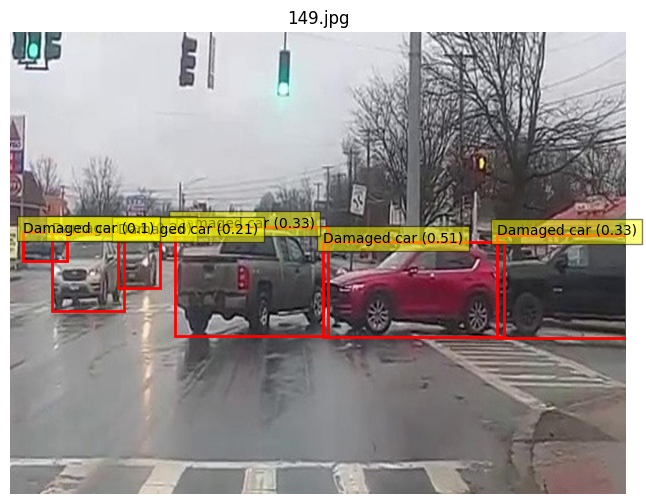

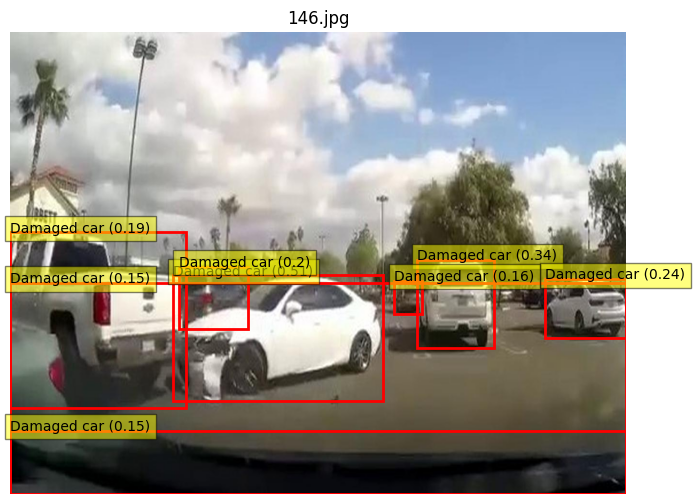

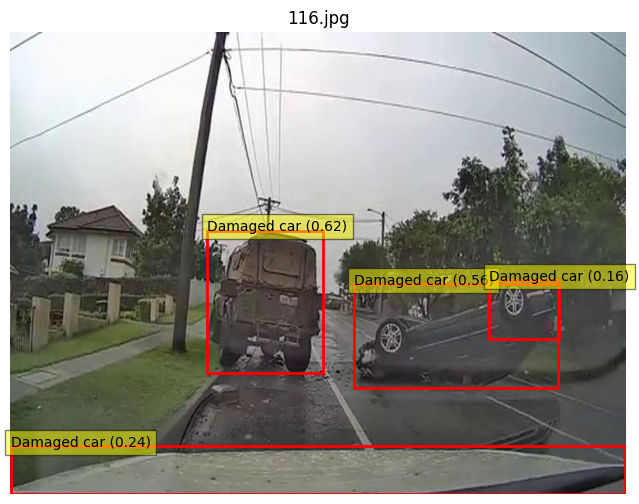

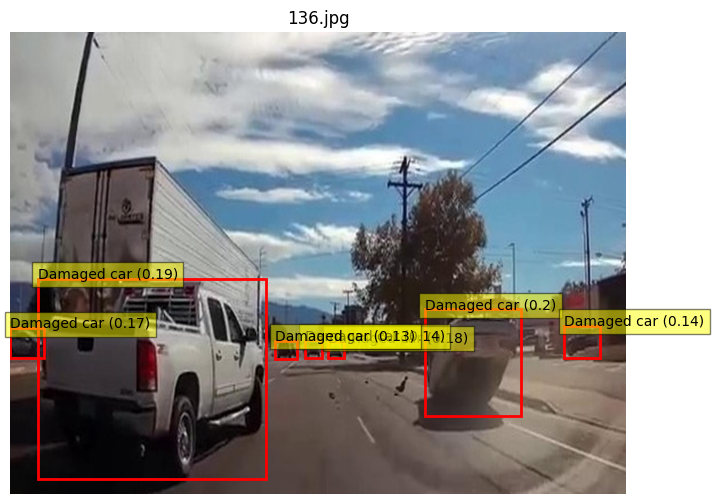

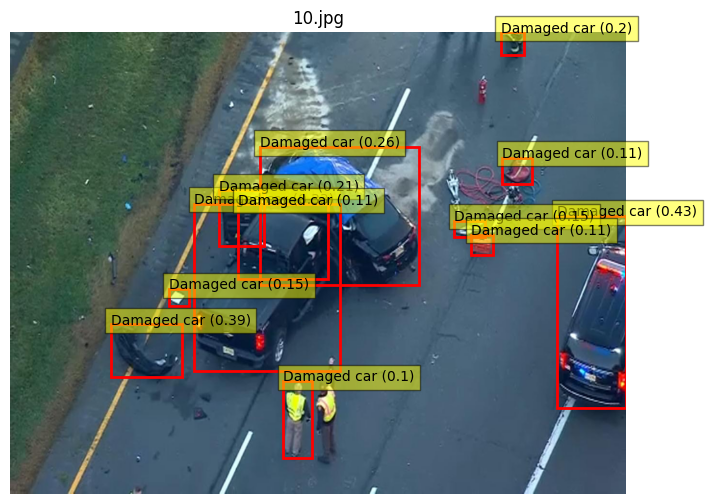

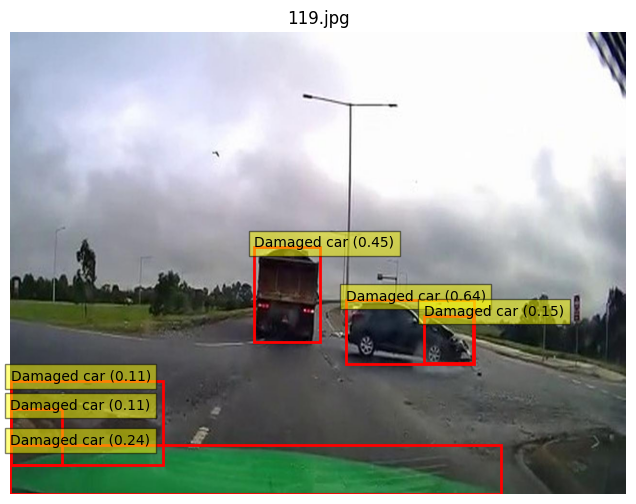

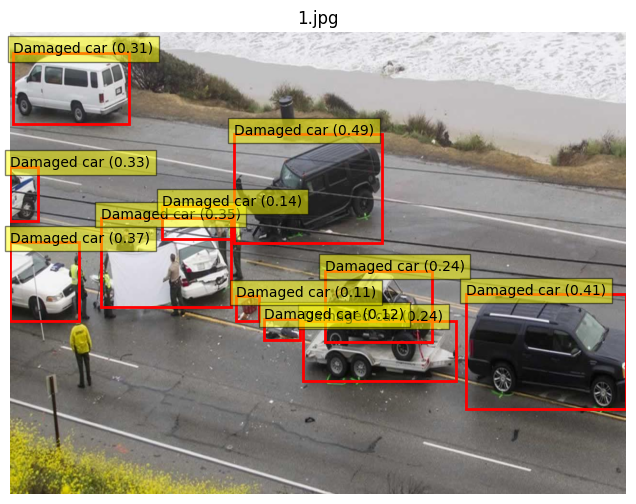

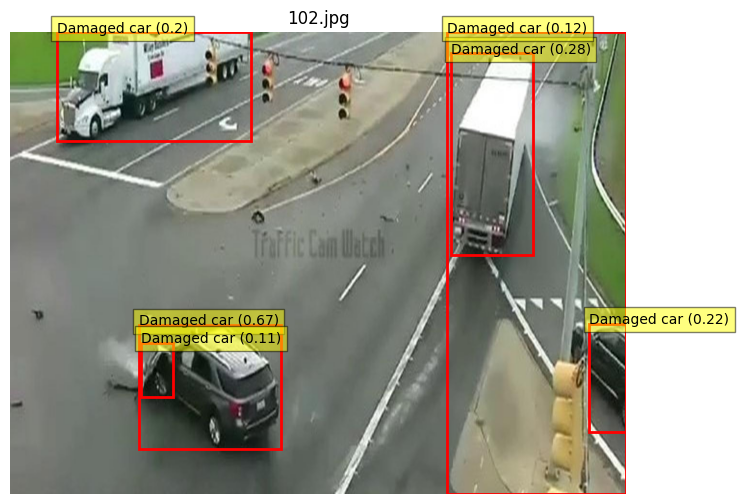

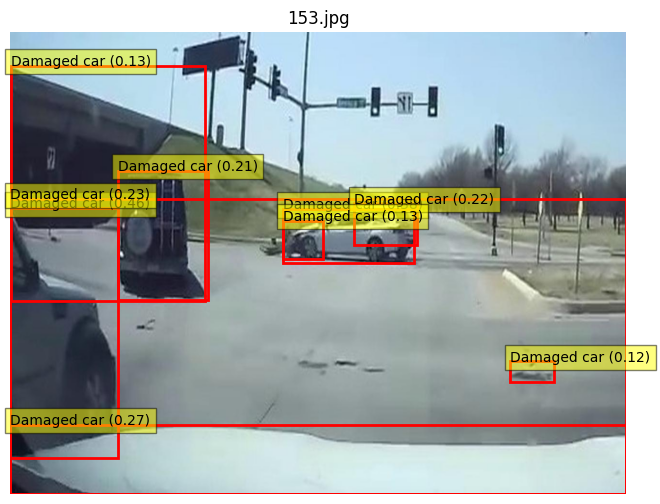

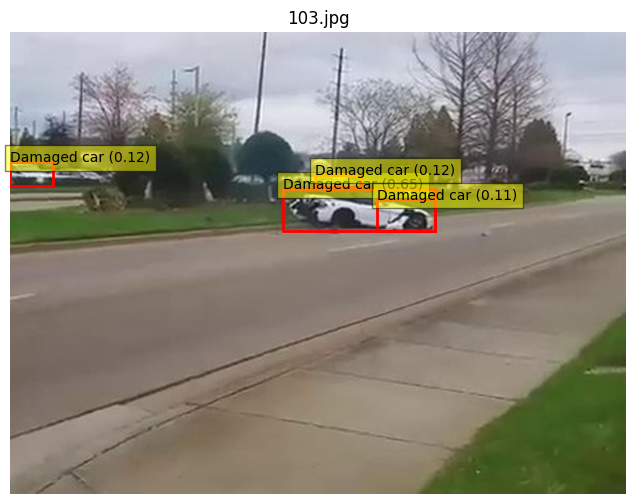

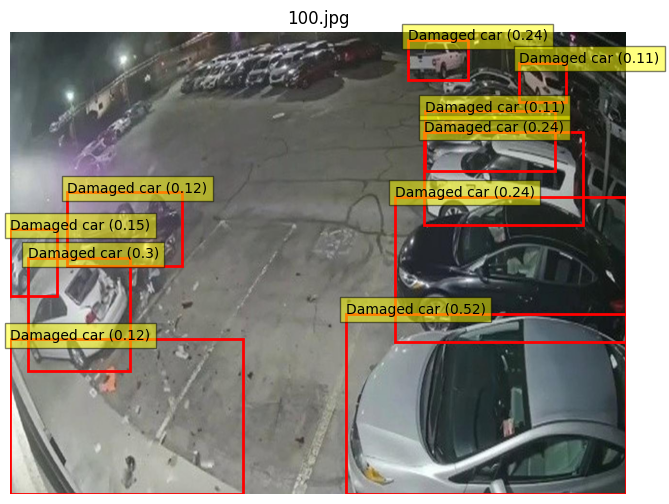

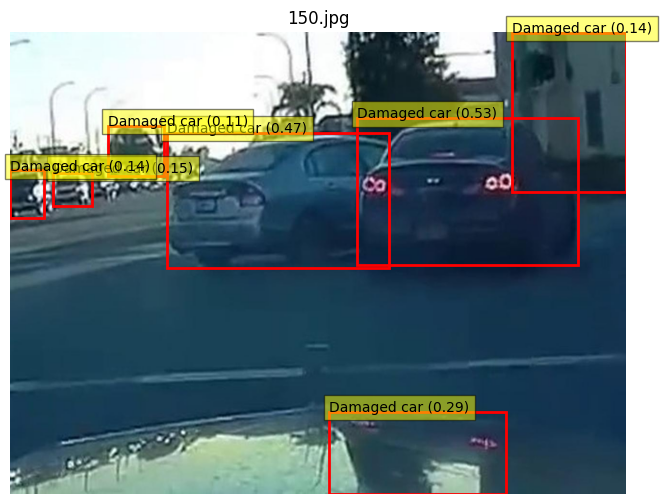

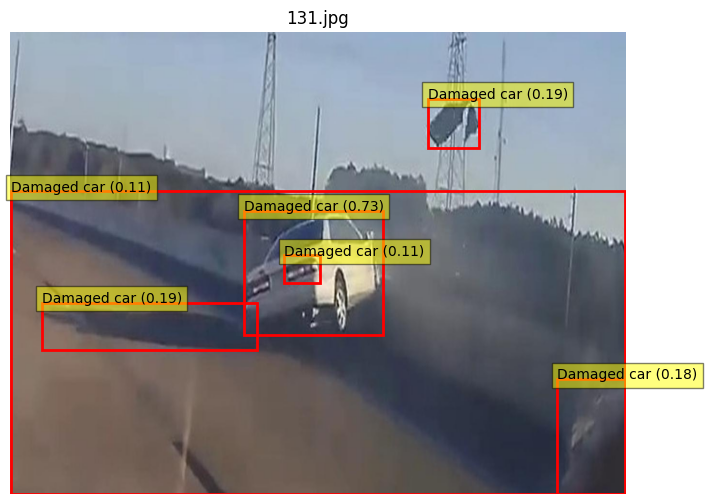

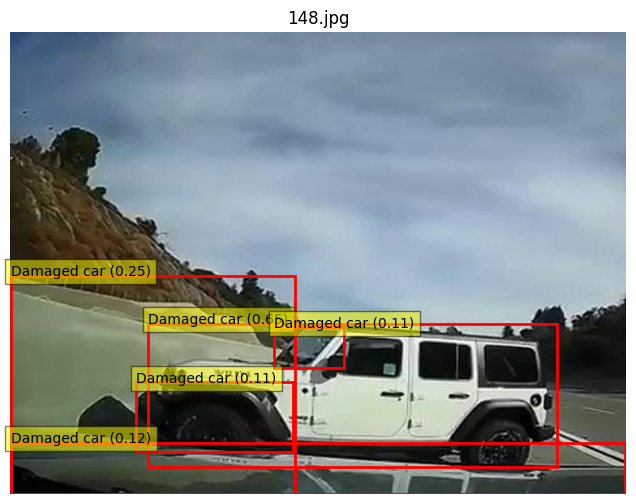

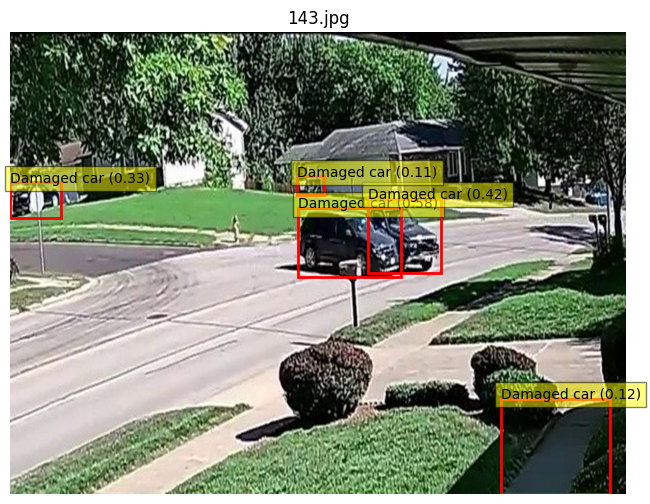

In [ ]:
def show_detections(image, detections, title=""):
    fig, ax = plt.subplots(1, figsize=(8, 6))
    ax.imshow(image)
    for score, label, box in zip(detections["scores"], detections["classes"], detections["boxes"]):
        x0, y0, x1, y1 = box.tolist()
        ax.add_patch(patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                                       linewidth=2, edgecolor='red', facecolor='none'))
        ax.text(x0, y0, f"{label} ({round(score.item(),2)})",
                bbox=dict(facecolor='yellow', alpha=0.5))
    ax.set_title(title)
    plt.axis('off')
    plt.show()

# Visualizza le prime 15 immagini annotate
for i in range(min(15, len(images))):
    show_detections(images[i], results[i], filenames[i])


#Saving Omdet predictions as Yolo format in a folder

In [ ]:
def save_omdet_predictions_as_yolo(results, images, filenames, classes, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for res, img, fname in zip(results, images, filenames):
        width, height = img.size
        name = os.path.splitext(fname)[0]  # rimuove .jpg ecc.
        txt_path = os.path.join(output_folder, f"{name}.txt")
        lines = []

        for box, label in zip(res["boxes"], res["classes"]):
            x1, y1, x2, y2 = box.tolist()

            cx = (x1 + x2) / 2 / width
            cy = (y1 + y2) / 2 / height
            w = (x2 - x1) / width
            h = (y2 - y1) / height
            class_id = classes.index(label)

            lines.append(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

        with open(txt_path, "w") as f:
            f.writelines(lines)


# Compute IoU

In [ ]:
def compute_iou(box1, box2):
    # Extracts values of two boxes
    cx1, cy1, w1, h1 = box1
    cx2, cy2, w2, h2 = box2

   # Convert from Yolo features to Corner box point: [cx, cy, w, h] → [x_min, y_min, x_max, y_max]
    x1_min = cx1 - w1 / 2
    y1_min = cy1 - h1 / 2
    x1_max = cx1 + w1 / 2
    y1_max = cy1 + h1 / 2

    x2_min = cx2 - w2 / 2
    y2_min = cy2 - h2 / 2
    x2_max = cx2 + w2 / 2
    y2_max = cy2 + h2 / 2

   # Calculate area of ​​intersection
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)

    # Calculate total areas and union area
    area1 = w1 * h1
    area2 = w2 * h2

    union_area = area1 + area2 - inter_area

    if union_area == 0:
        return 0.0
    # Calculate IoU
    iou = inter_area / union_area
    return round(iou, 4)

# Calculate average IoU for each file and class

In [ ]:
def evaluate_model(gt_folder, predicted_folder, class_names):
    global_ious = []
    class_ious = defaultdict(list)

    for filename in sorted(os.listdir(gt_folder)):
        if not filename.endswith(".txt"):
            continue

        gt_path = os.path.join(gt_folder, filename)
        pred_path = os.path.join(predicted_folder, filename)

        if not os.path.exists(pred_path):
            print(f"⚠️ Predizione mancante per {filename}")
            continue

        # Leggi GT e predizioni
        with open(gt_path, 'r') as f:
            gt_boxes = [list(map(float, line.strip().split())) for line in f if line.strip()]

        with open(pred_path, 'r') as f:
            pred_boxes = [list(map(float, line.strip().split())) for line in f if line.strip()]

        file_ious = []

        for gt in gt_boxes:
            gt_class = int(gt[0])
            gt_box = gt[1:]

            # Trova le predizioni della stessa classe
            matching_preds = [pred[1:] for pred in pred_boxes if int(pred[0]) == gt_class]

            best_iou = 0.0
            for pred_box in matching_preds:
                iou = compute_iou(gt_box, pred_box)
                best_iou = max(best_iou, iou)

            # Registra l'IoU migliore per questa classe
            class_ious[gt_class].append(best_iou)
            global_ious.append(best_iou)
            file_ious.append(best_iou)

        if file_ious:
            avg_file_iou = sum(file_ious) / len(file_ious)
            print(f"📁 {filename} — media IoU = {avg_file_iou:.4f}")
        else:
            print(f"📁 {filename} — ⚠️ Nessun box confrontabile.")

    # Report per classe
    print("\n📊 Media IoU per classe:")
    for class_id in range(len(class_names)):
        ious = class_ious.get(class_id, [])
        if ious:
            avg_class_iou = sum(ious) / len(ious)
            print(f"  • {class_names[class_id]}: {avg_class_iou:.4f} su {len(ious)} box")
        else:
            print(f"  • {class_names[class_id]}: Nessun box valutato.")

    # Media globale
    if global_ious:
        avg_iou = sum(global_ious) / len(global_ious)
        print(f"\n✅ Media IoU globale dei box: {avg_iou:.4f}")
    else:
        print("\n❌ Nessun confronto valido effettuato.")

# Compute mAP

In [ ]:
def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    gt_matched = [False] * len(gt_boxes)
    pred_matched = [False] * len(pred_boxes)
    tp, fp = 0, 0

    for pred in pred_boxes:
        matched = False
        for idx, gt in enumerate(gt_boxes):
            if gt_matched[idx]:
                continue
            iou = compute_iou(gt[1:], pred[1:])
            if iou >= iou_threshold:
                matched = True
                gt_matched[idx] = True
                pred_matched[pred_boxes.index(pred)] = True
                break
        if matched:
            tp += 1
        else:
            fp += 1

    fn = gt_matched.count(False)
    return tp, fp, fn

def compute_map(gt_folder, pred_folder, iou_thresholds=[0.5]):
    all_precisions = []
    all_recalls = []

    for iou_thresh in iou_thresholds:
        tps, fps, fns = 0, 0, 0
        for filename in os.listdir(gt_folder):
            if not filename.endswith(".txt"):
                continue

            gt_path = os.path.join(gt_folder, filename)
            pred_path = os.path.join(pred_folder, filename)

            if not os.path.exists(pred_path):
                continue

            with open(gt_path, 'r') as f:
                gt_boxes = [list(map(float, line.strip().split())) for line in f if line.strip()]
            with open(pred_path, 'r') as f:
                pred_boxes = [list(map(float, line.strip().split())) for line in f if line.strip()]

            tp, fp, fn = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=iou_thresh)
            tps += tp
            fps += fp
            fns += fn

        precision = tps / (tps + fps) if (tps + fps) > 0 else 0.0
        recall = tps / (tps + fns) if (tps + fns) > 0 else 0.0
        all_precisions.append(precision)
        all_recalls.append(recall)

        print(f"IoU ≥ {iou_thresh:.2f} → Precision: {precision:.4f} | Recall: {recall:.4f}")

    map_score = sum(all_precisions) / len(iou_thresholds) if iou_thresholds else 0.0
    print(f"\n📊 mAP@[{iou_thresholds[0]:.2f}-{iou_thresholds[-1]:.2f}]: {map_score:.4f}")
    return map_score


In [ ]:
# === Ground truth folder paths and predicted model annotations folder ===
gt_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/annotations"
pred_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/Omdet-turboAnnotations"
save_omdet_predictions_as_yolo(results, images, filenames, classes, pred_folder)

evaluate_model(gt_folder, pred_folder,classes)
compute_map(gt_folder, pred_folder, iou_thresholds=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75])


📁 1.txt — media IoU = 0.6646
📁 10.txt — media IoU = 0.4489
📁 100.txt — media IoU = 0.6601
📁 101.txt — media IoU = 0.7867
📁 102.txt — media IoU = 0.4330
📁 103.txt — media IoU = 0.5726
📁 104.txt — media IoU = 0.5422
📁 105.txt — media IoU = 0.6587
📁 106.txt — media IoU = 0.4893
📁 107.txt — media IoU = 0.7086
📁 108.txt — media IoU = 0.6976
📁 109.txt — media IoU = 0.0000
📁 11.txt — media IoU = 0.7108
📁 110.txt — media IoU = 0.6385
📁 111.txt — media IoU = 0.7136
📁 112.txt — media IoU = 0.5615
📁 113.txt — media IoU = 0.6988
📁 114.txt — media IoU = 0.5507
📁 115.txt — media IoU = 0.5187
📁 116.txt — media IoU = 0.3445
📁 117.txt — media IoU = 0.7580
📁 118.txt — media IoU = 0.7289
📁 119.txt — media IoU = 0.2493
📁 12.txt — media IoU = 0.7626
📁 120.txt — media IoU = 0.6860
📁 121.txt — media IoU = 0.5859
📁 122.txt — media IoU = 0.7153
📁 123.txt — media IoU = 0.5700
📁 124.txt — media IoU = 0.7038
📁 125.txt — media IoU = 0.8734
📁 126.txt — media IoU = 0.7923
📁 127.txt — media IoU = 0.8279
📁 128.txt — m

0.16627067933826117